In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')


In [2]:
%%px
# Import the libraries

import pyfftw as ft 
import numpy as np
from mpi4py import MPI
import math
import sys
import os
import SOAPtdb
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from FFT3Dfield import FFT3Dfield
from IFFT3Dfield import IFFT3Dfield
from EnergySpectrum import EnergySpectrum
from Filters import Filters
from RandomNumberGenerator import RandomNumberGenerator

In [3]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']
xnodes = isotropic1024coarse['xnodes']
ynodes = isotropic1024coarse['ynodes']
znodes = isotropic1024coarse['znodes']

In [4]:
%%px

comm = MPI.COMM_WORLD
my_id = comm.Get_rank()
nproc = comm.Get_size()
if(my_id==0):
    print("n_proc = "+str(nproc))
    print("my_id = "+str(my_id))

[stdout:4] 
n_proc = 8
my_id = 0


In [5]:
%%px 
# Computational Domain

nx=Nx//nproc
ny=Ny
nz=Nz#//nproc
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)

In [6]:
%%px 

time = 0.0

chkSz = 32
slabs = nx//chkSz

##########################################

if(my_id==0):
    print("Preparing the appropiate widths")
    
##########################################

[stdout:4] Preparing the appropiate widths


In [7]:
%%px
# Populate velocity field from the Database
comm.Barrier(); t1=MPI.Wtime()

if(my_id==0):
    print("Starting the loading process")

##########################################

lJHTDB = libJHTDB()
lJHTDB.initialize()
ud = []
for k in range(slabs):
    if(my_id==0):
        print(k)
    start = np.array([my_id*nx+k*chkSz, 0, 0],dtype=np.int)
    width = np.array([chkSz,ny,nz],dtype=np.int)
    #start = np.array([ 0, 0, my_id*nx+k*chkSz],dtype=np.int)
    ud.append(lJHTDB.getRawData(time,start,width, 
                               data_set = 'isotropic1024coarse',
                               getFunction = 'Velocity') )

lJHTDB.finalize()

if(my_id==0):
    print("Finished loading")

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Load velocity field cost: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] 
Starting the loading process
0
1
2
3
Finished loading
Load velocity field cost: 203.47 seconds


In [15]:
%%px

u = np.concatenate(ud,axis=2)
#u = np.concatenate(ud,axis=0)

if(my_id==0):
    print('u.shape: '+str(u.shape))

[stdout:4] u.shape: (1024, 1024, 128, 3)


In [16]:
%%px

rsh = np.transpose(u,(2,1,0,3)) #u.reshape((nx,ny,nz, 3))

In [17]:
%%px
##########################################
vx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
vy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
vz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

vx[:,:,:] = rsh[:,:,:,0]
vy[:,:,:] = rsh[:,:,:,1]
vz[:,:,:] = rsh[:,:,:,2]

if(my_id==0):
    print("vx shape = "+str(vx.shape))

if(my_id==0):
    print("Spliting")

##########################################

[stdout:4] 
vx shape = (128, 1024, 1024)
Spliting


In [18]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get wavenumber:
myEnergySpc=EnergySpectrum()
kx,ky,kz=myEnergySpc.FindWavenumber(nx,ny,nz,my_id)
k2=np.zeros((nx,ny,nz_half+1), dtype='float32')
np.copyto(k2,kx*kx+ky*ky+kz*kz)
k2[0,0,0]=1e-6

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate all wavenumbers: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate all wavenumbers: 11.33 seconds


In [19]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:
myFFT3Dfield=FFT3Dfield()
cvx=myFFT3Dfield.GetFFT3Dfield(vx,nx,ny,nz,nproc,my_id)
cvy=myFFT3Dfield.GetFFT3Dfield(vy,nx,ny,nz,nproc,my_id)
cvz=myFFT3Dfield.GetFFT3Dfield(vz,nx,ny,nz,nproc,my_id)

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 3D spatial FFT: 73.77 seconds


In [20]:
%%px
comm.Barrier(); t1=MPI.Wtime()
## Get energy spectrum in Fourier space
ek_unfltrd=myEnergySpc.GetSpectrumFromComplexField(cvx,cvy,cvz,k2,nx,ny,nz,nek,nproc,my_id)

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate 3D energy spectra: {0:.2f} seconds\n'.format(t2-t1))

[output:4]

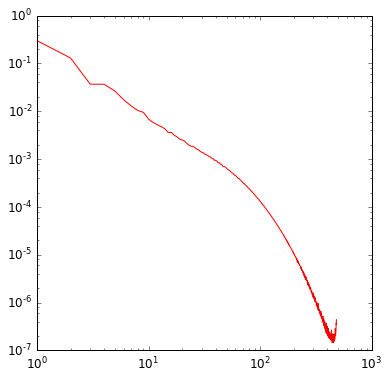

In [21]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
if my_id==0:
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    ks=np.linspace(1,nek,nek)
    plt.figure(figsize=(6,6))

    plt.loglog(ks,ek_unfltrd,'r',label='Unfiltered')
    plt.loglog(ks,np.power(ks,-5/3),'k')